# Time Series Forecast Analysis of Hospital System Revenue Code

## Research Question

Can the hospital's daily revenue for January of 2023 be effectively forecasted based on the actual values from the first two years of operation?

## Install Necessary Libraries

In [1]:
# For General Use:
!pip install pandas
!pip install numpy

# For ARIMA:
!pip install pmdarima

## Install Necessary Packages

In [2]:
# General Use:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# For Stationarity:
from statsmodels.tsa.stattools import adfuller

# For ACF:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# For PACF:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# For Decomposition:
from statsmodels.tsa.seasonal import seasonal_decompose

# For ARIMA:
import pmdarima as pm
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA

## Load Data Set and Explore

In [3]:
# Load CSV to a data frame.
med_time_series = pd.read_csv('medical_time_series .csv')

# Review data frame to ensure all is loaded as expected.
med_time_series.info()

# Print data frame.
print(med_time_series)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB
     Day    Revenue
0      1   0.000000
1      2  -0.292356
2      3  -0.327772
3      4  -0.339987
4      5  -0.124888
..   ...        ...
726  727  15.722056
727  728  15.865822
728  729  15.708988
729  730  15.822867
730  731  16.069429

[731 rows x 2 columns]


In [4]:
# Print the describe information to see an overview of the values.
med_time_series.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


## Clean and Prepare Data

In [5]:
# Identify and drop duplicated values.
med_time_series = med_time_series.drop_duplicates(subset='Day', keep='first')

# Review data frame information to see if any drops were made.
med_time_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 17.1 KB


There are still 731 rows remaining showing that no values were dropped.  This indicates there were no duplicated values.

In [6]:
# Sum all null values based on each variable to review for any missing data.
med_time_series.isnull().sum()

Day        0
Revenue    0
dtype: int64

There are no null values present in either columns.

In [7]:
# Convert Date column values to Date to ensure best performance and presentation.

# Assign a start date for the first day that is tracked.
start_date = '2021-01-01'

# Create the date range for the Date column based on the start date.
med_time_series['Date'] = pd.date_range(start=start_date, periods=len(med_time_series), freq='D')

# Assign the Date column as the index for the data frame.
med_time_series.set_index('Date', inplace = True)

# Review data frame with new index Date.
med_time_series

,Day,Revenue
Date,,
2021-01-01,1,0.000000
2021-01-02,2,-0.292356
2021-01-03,3,-0.327772
2021-01-04,4,-0.339987
2021-01-05,5,-0.124888
...,...,...
2022-12-28,727,15.722056
2022-12-29,728,15.865822
2022-12-30,729,15.708988


In [8]:
# Drop Day column now that there is the Date index.
med_time_series.drop('Day', axis=1, inplace=True)

# Review data frame with Day column dropped.
med_time_series

,Revenue
Date,
2021-01-01,0.000000
2021-01-02,-0.292356
2021-01-03,-0.327772
2021-01-04,-0.339987
2021-01-05,-0.124888
...,...
2022-12-28,15.722056
2022-12-29,15.865822
2022-12-30,15.708988


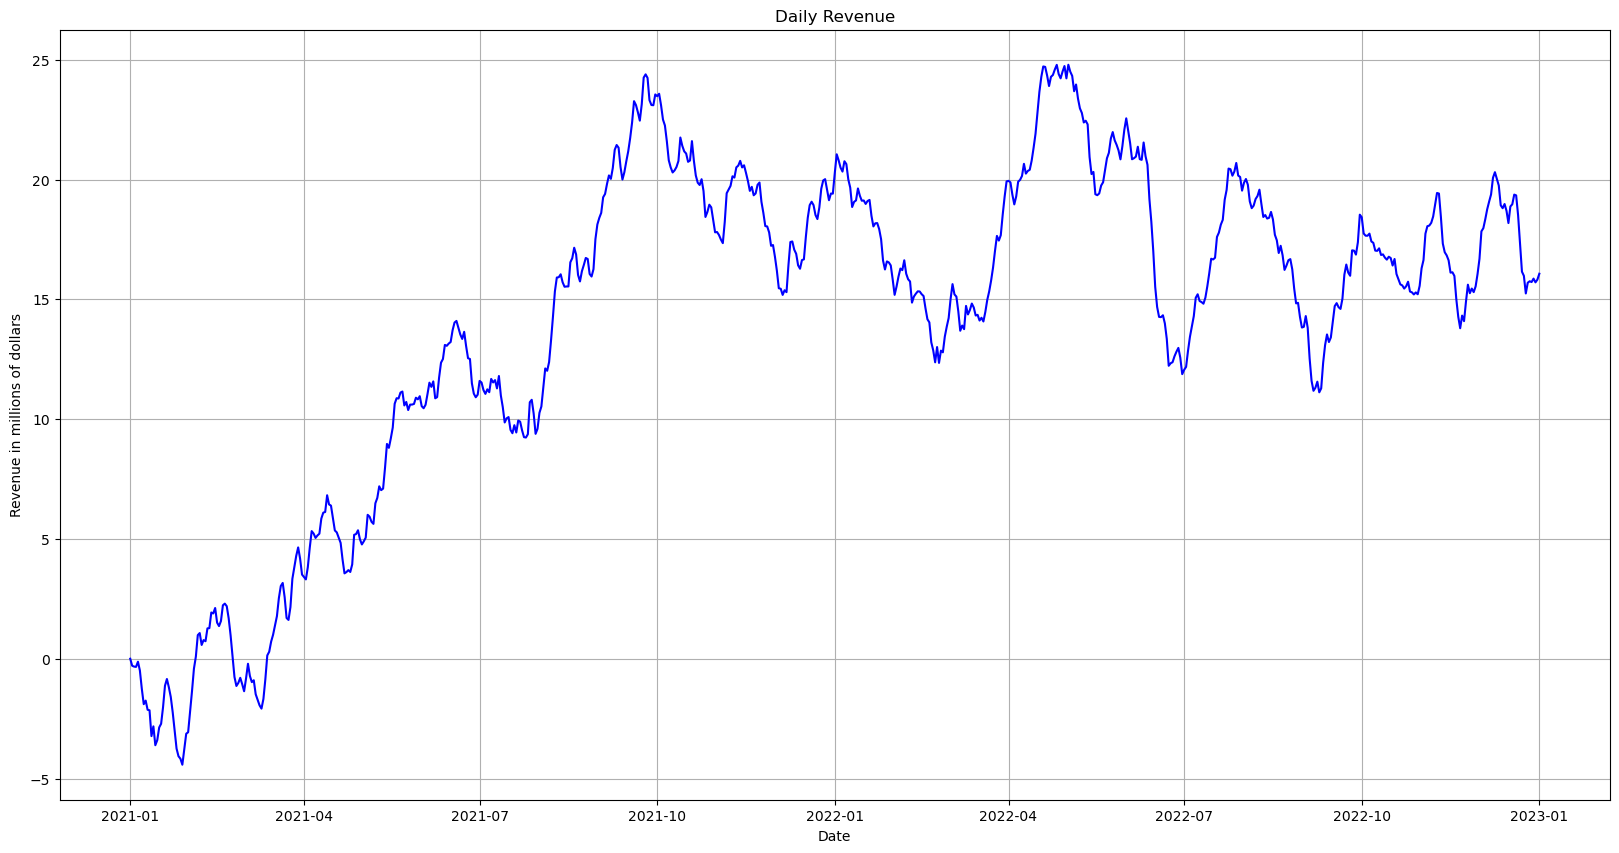

In [9]:
# Create a graph to show visual representation of the data frame.
plt.figure(figsize=(20,10))
plt.plot(med_time_series.Revenue, color='blue')
plt.title('Daily Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue in millions of dollars')
plt.grid(True)
plt.show()

## Check for Stationarity

In [10]:
# Perform the Dickey-Fuller test.
df_result = adfuller(med_time_series['Revenue'])

# Extract the p-value.
p_value = round(df_result[1], 4)

# View the p-value result of the Dickey-Fuller test.
print(f"The p-value is: {p_value}.")
if p_value <= 0.05:
    print("This means the time series is stationary as the p-value is less than 0.05.")
else:
    print("This means the time series is not stationary as the p-value is greater than 0.05.")

The p-value is: 0.1997.
This means the time series is not stationary as the p-value is greater than 0.05.


In [11]:
# Calculate the rolling mean of the series for each month.
roll_mean = med_time_series.rolling(window=12).mean()

# Calculate the rolling standard deviation of the series for each month.
roll_std = med_time_series.rolling(window=12).std()

# Print the calculated values for the rolling mean and rolling standard deviation.
print(roll_mean, roll_std)

              Revenue
Date                 
2021-01-01        NaN
2021-01-02        NaN
2021-01-03        NaN
2021-01-04        NaN
2021-01-05        NaN
...               ...
2022-12-28  17.246163
2022-12-29  16.995334
2022-12-30  16.723707
2022-12-31  16.427933
2023-01-01  16.155528

[731 rows x 1 columns]              Revenue
Date                
2021-01-01       NaN
2021-01-02       NaN
2021-01-03       NaN
2021-01-04       NaN
2021-01-05       NaN
...              ...
2022-12-28  1.648115
2022-12-29  1.606064
2022-12-30  1.515067
2022-12-31  1.279104
2023-01-01  0.892651

[731 rows x 1 columns]


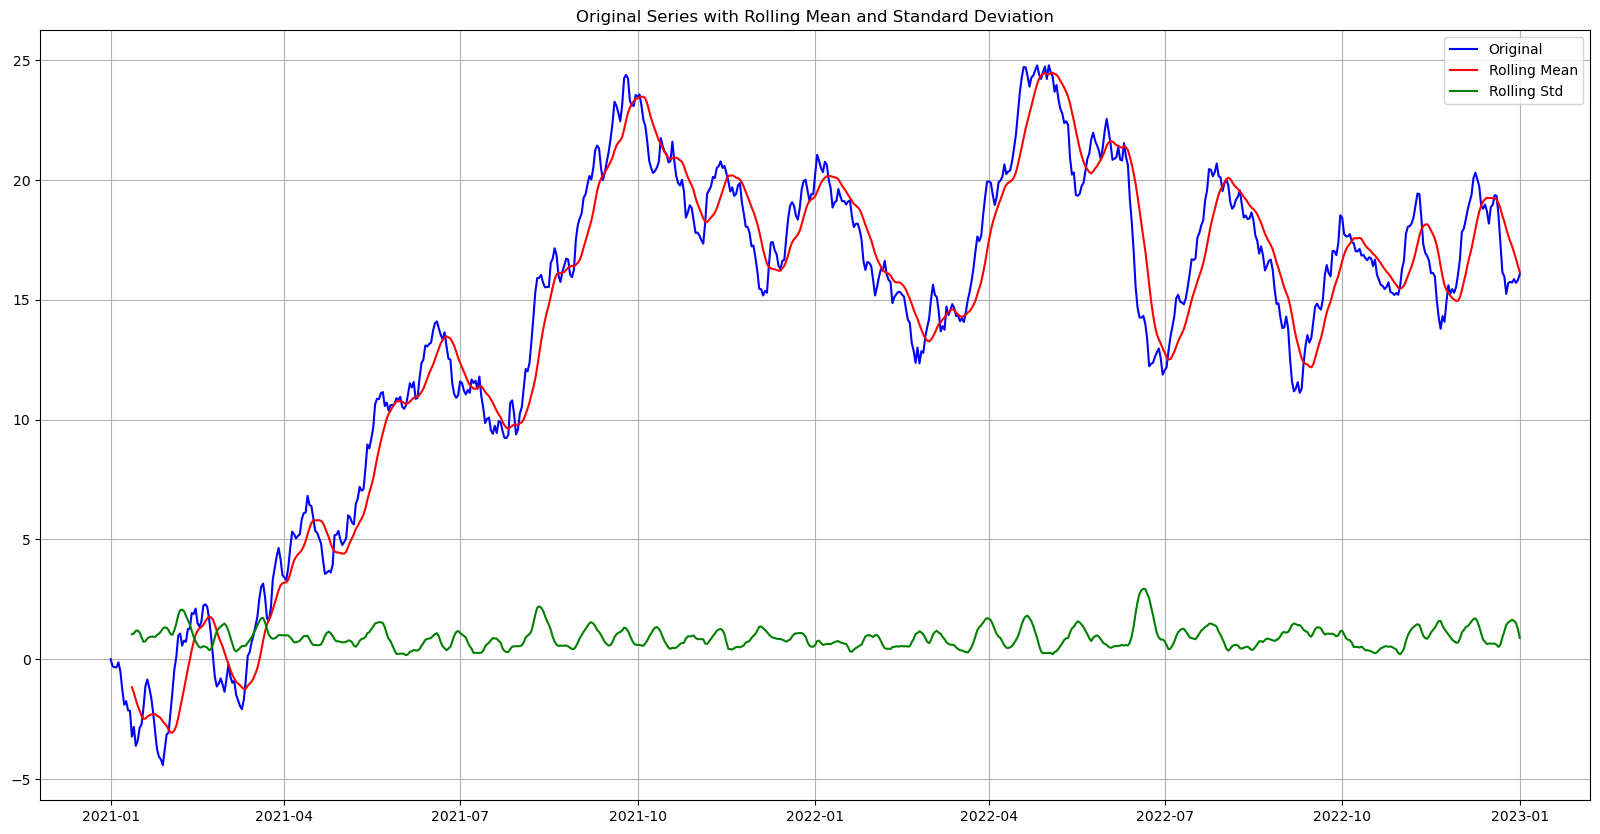

In [12]:
# Plot the original series with the rolling mean and rolling standard deviation to review stationarity.
plt.figure(figsize = (20, 10))
original = plt.plot(med_time_series, color='blue', label='Original')
mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
std = plt.plot(roll_std, color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Original Series with Rolling Mean and Standard Deviation')
plt.grid(True)
plt.show()

The p-value result from the Dickey-Fuller test and the graphical representation show that the data is not stationary.  Differencing will need to be used to get the data stationary.

## Make Data Stationary

In [13]:
# Use differencing to make the series stationary.
med_time_series['Stationary_Series'] = med_time_series['Revenue'].diff(periods=1)

# Review the data frame to ensure that the differenced values are present.
med_time_series

,Revenue,Stationary_Series
Date,,
2021-01-01,0.000000,NaN
2021-01-02,-0.292356,-0.292356
2021-01-03,-0.327772,-0.035416
2021-01-04,-0.339987,-0.012215
2021-01-05,-0.124888,0.215100
...,...,...
2022-12-28,15.722056,-0.032693
2022-12-29,15.865822,0.143766
2022-12-30,15.708988,-0.156834


In [14]:
# Fill NaN values to run Dickey-Fuller test.
med_time_series['Stationary_Series'] = med_time_series['Stationary_Series'].fillna(0)

# Review stationary series to ensure NaN values are replaced with "0".
med_time_series

,Revenue,Stationary_Series
Date,,
2021-01-01,0.000000,0.000000
2021-01-02,-0.292356,-0.292356
2021-01-03,-0.327772,-0.035416
2021-01-04,-0.339987,-0.012215
2021-01-05,-0.124888,0.215100
...,...,...
2022-12-28,15.722056,-0.032693
2022-12-29,15.865822,0.143766
2022-12-30,15.708988,-0.156834


In [15]:
# Perform the Dickey-Fuller test.
df_stationary_result = adfuller(med_time_series['Stationary_Series'])

# Extract the p-value.
stationary_p_value = round(df_stationary_result[1], 4)

# View the p-value result of the Dickey-Fuller test.
print(f"The p-value is: {stationary_p_value}.")
if stationary_p_value <= 0.05:
    print("This means the time series is stationary as the p-value is less than 0.05.")
else:
    print("This means the time series is not stationary as the p-value is greater than 0.05.")

The p-value is: 0.0.
This means the time series is stationary as the p-value is less than 0.05.


In [16]:
# Calculate the rolling mean of the staionary series for each month.
stat_roll_mean = med_time_series['Stationary_Series'].rolling(window=12).mean()
stat_roll_mean = stat_roll_mean.fillna(0)

# Calculate the rolling standard deviation of the stationary series for each month.
stat_roll_std = med_time_series['Stationary_Series'].rolling(window=12).std()
stat_roll_std = stat_roll_std.fillna(0)

# Print the calculated values for the stationary rolling mean and rolling standard deviation.
print(stat_roll_mean, stat_roll_std)

Date
2021-01-01    0.000000
2021-01-02    0.000000
2021-01-03    0.000000
2021-01-04    0.000000
2021-01-05    0.000000
                ...   
2022-12-28   -0.205178
2022-12-29   -0.250829
2022-12-30   -0.271628
2022-12-31   -0.295773
2023-01-01   -0.272405
Name: Stationary_Series, Length: 731, dtype: float64 Date
2021-01-01    0.000000
2021-01-02    0.000000
2021-01-03    0.000000
2021-01-04    0.000000
2021-01-05    0.000000
                ...   
2022-12-28    0.631149
2022-12-29    0.577961
2022-12-30    0.568892
2022-12-31    0.543195
2023-01-01    0.561220
Name: Stationary_Series, Length: 731, dtype: float64


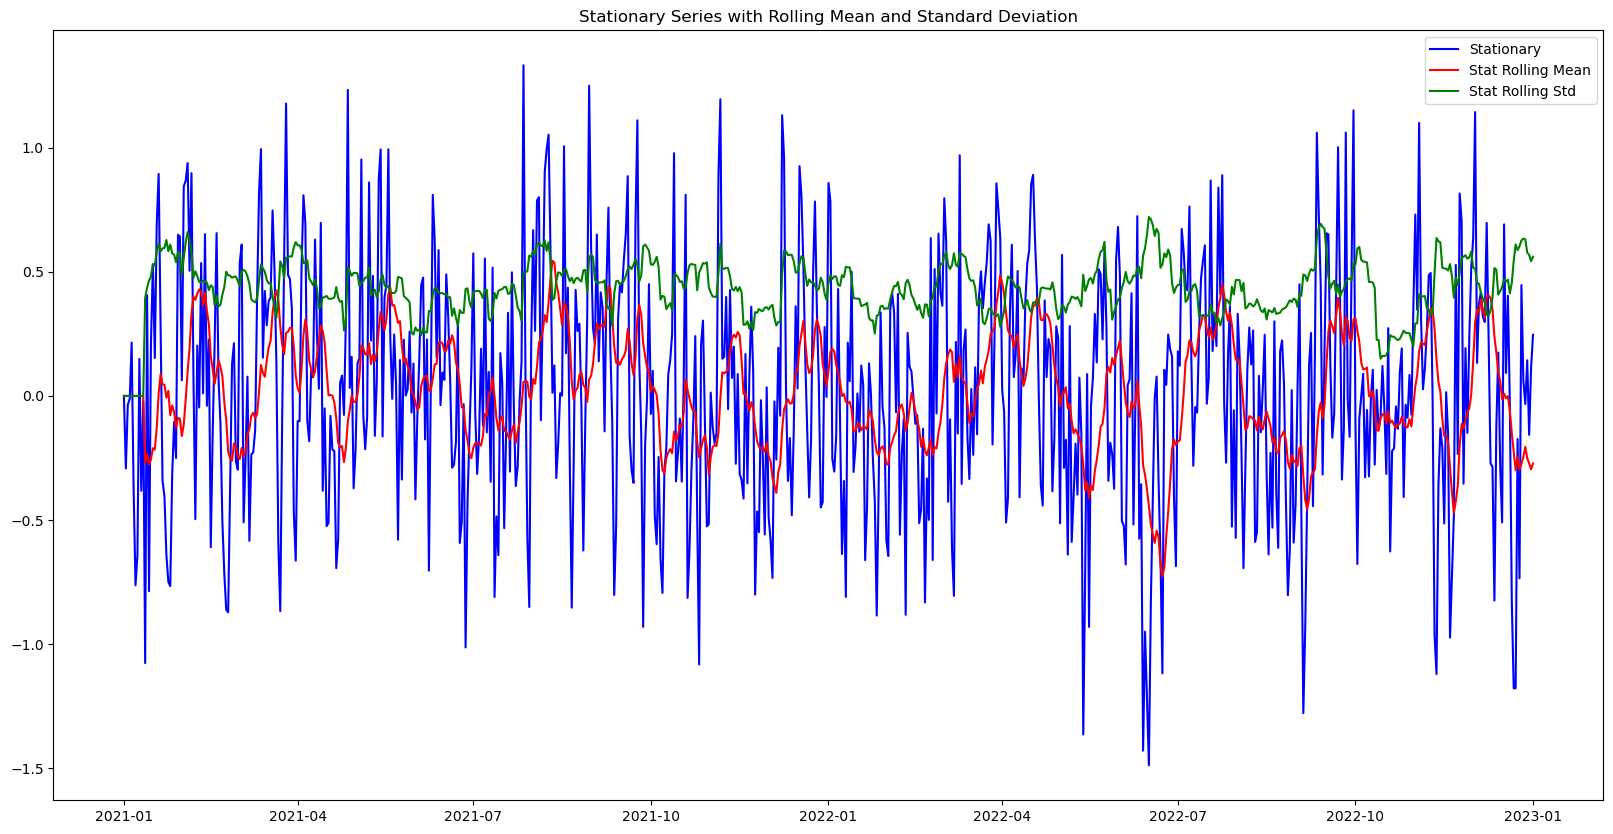

In [17]:
# Plot the stationary series with the rolling mean and rolling standard deviation to review stationarity.
plt.figure(figsize = (20, 10))
stationary = plt.plot(med_time_series['Stationary_Series'], color='blue', label='Stationary')
stat_mean = plt.plot(stat_roll_mean, color='red', label='Stat Rolling Mean')
stat_std = plt.plot(stat_roll_std, color='green', label='Stat Rolling Std')
plt.legend(loc='best')
plt.title('Stationary Series with Rolling Mean and Standard Deviation')
plt.show()

The p-value result from the Dickey-Fuller test and the graphical representation show that the data is now stationary.

## Export Data Set

In [18]:
# Export the cleaned data set as a .csv file.
med_time_series.to_csv("med_time_series.csv")

## ACF

[ 1.00000000e+00  4.13241899e-01  1.78287225e-01  2.38792135e-02
  2.84774830e-02  5.95156643e-02  9.93498669e-02  8.14913073e-02
  8.01632289e-02  6.41814632e-02  2.45796624e-02 -4.78919889e-02
 -8.09436371e-02 -2.47740073e-02  4.45819503e-03  2.98247532e-02
  2.38976187e-02 -7.70403101e-04 -7.09683127e-02 -6.62826988e-02
 -1.29837242e-01 -9.37667883e-02 -6.79835532e-02 -1.95798788e-02
  9.14388956e-04 -3.10477098e-02 -4.58638878e-02 -3.55593140e-02
 -2.06849557e-02]


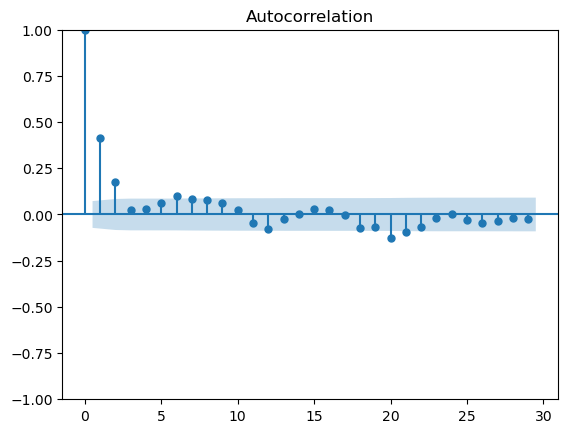

In [19]:
# Set up ACF calculation.
acf_values = acf(med_time_series['Stationary_Series'])

# View the calculated ACF values.
print(acf_values)

# Plot the calculated ACF values.
plot_acf(med_time_series['Stationary_Series'], alpha=0.05)
plt.show()

## PACF

[ 1.00000000e+00  4.13807984e-01  9.09705934e-03 -6.40681429e-02
  4.72284632e-02  5.17946298e-02  6.14174107e-02  1.31892376e-02
  3.90444147e-02  2.22135639e-02 -2.14588567e-02 -7.33713945e-02
 -5.09395879e-02  3.72693728e-02 -2.43643780e-04  1.31581067e-02
  8.14595510e-03 -8.11049111e-03 -7.29549476e-02 -7.31914229e-03
 -1.02503351e-01 -1.01716451e-02 -1.73974919e-02  7.85594613e-03
  1.69091517e-02 -3.25378383e-02  2.47305494e-04  1.75693360e-02
  1.03514724e-02]


C:\Users\chris\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


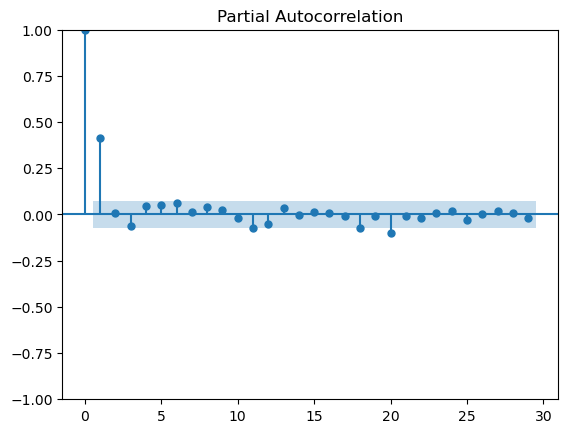

In [20]:
# Set up PACF calculation.
pacf_values = pacf(med_time_series['Stationary_Series'])

# View the calculated PACF values.
print(pacf_values)

# plot the calculated PACF values.
plot_pacf(med_time_series['Stationary_Series'], alpha=0.05)
plt.show()

## Spectral Density

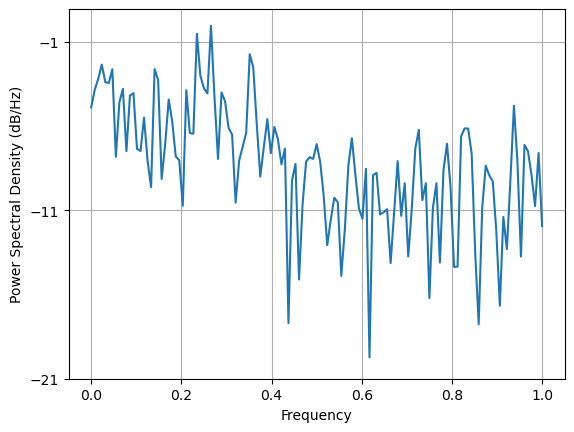

In [21]:
# Plot the spectral density of the data.
plt.psd(med_time_series['Stationary_Series'])
plt.show()

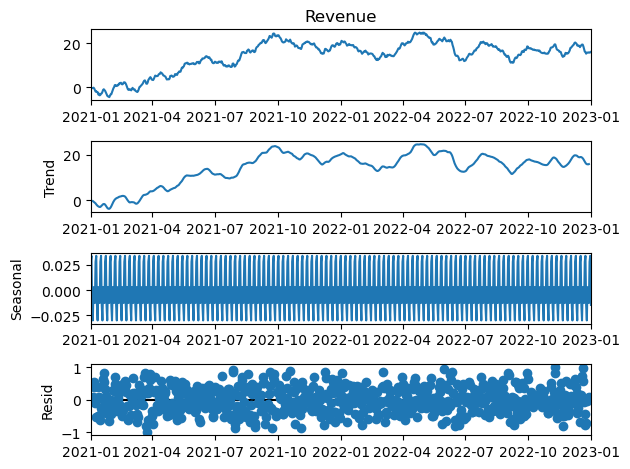

In [22]:
# Set up decomposition.
decomp_result = seasonal_decompose(med_time_series.Revenue, model="additive")

# Plot decomposition.
decomp_result.plot()
plt.show()

Text(0.5, 1.0, 'Decomposition Seasonal Zoom')

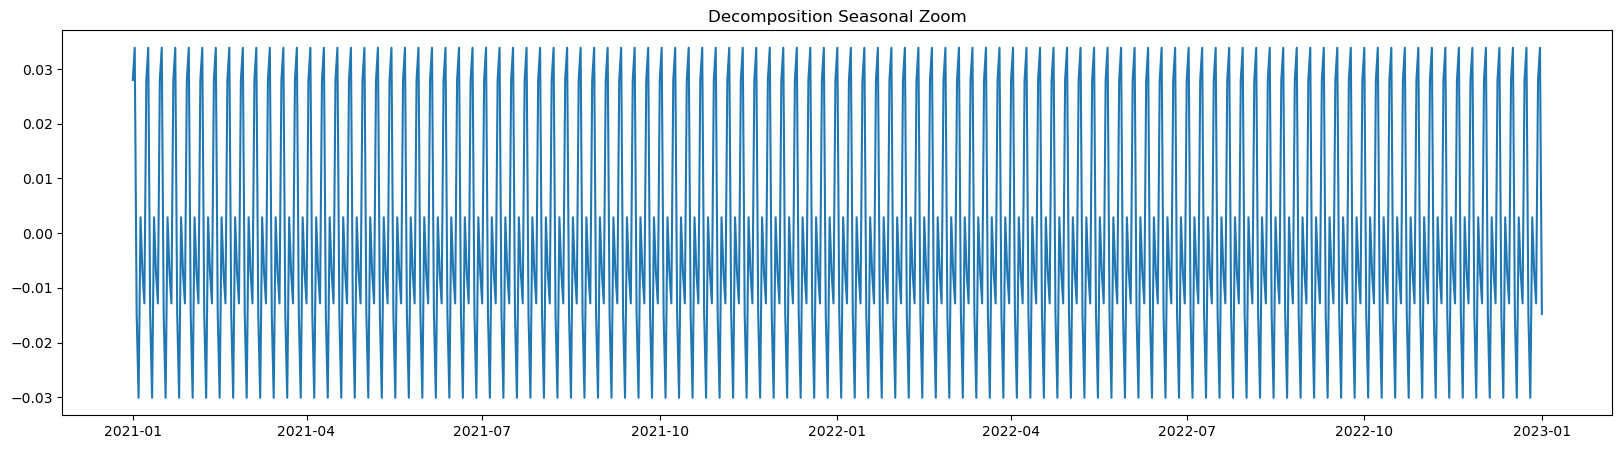

In [23]:
# Plot a zoomed in version of Seasonal plot to confirm seasonality.
plt.figure(figsize = [20, 5])
plt.plot(decomp_result.seasonal)
plt.title('Decomposition Seasonal Zoom')

Zoomed in plot verifies that there is no clear seasonality in the data.

Text(0.5, 1.0, 'Decomposition Resid Zoom')

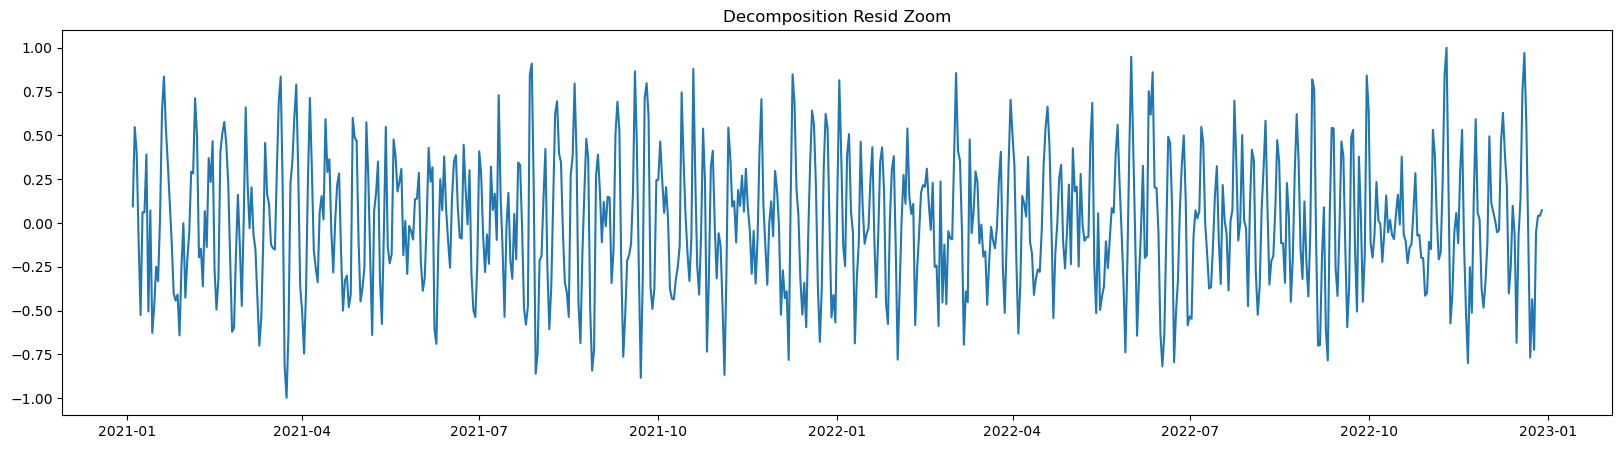

In [24]:
# Plot a zoomed in version of Resid plot to confirm trends.
plt.figure(figsize = [20, 5])
plt.plot(decomp_result.resid)
plt.title('Decomposition Resid Zoom')

Zoomed in plot verifies that there are no clear trends in the data.

## Auto ARIMA Test

In [25]:
# Set warnings.
warnings.filterwarnings("ignore")

# Set up step wise model to determine p, d, and q values.
auto_stepwise = auto_arima(med_time_series['Revenue'], trace=True, suppress_warnings=True)

# Review auto ARIMA test results.
auto_stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.132 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -437.991
Date:                Sun, 18 Feb 2024   AIC                            879.982
Time:                        09:15:00   BIC                            889.168
Sample:                    01-01-2021   HQIC                           883.526
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.90   Prob(JB):                         0.38
Heteroskedasticity (H):               1.00   Skew:                            -0.02
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Manual ARIMA Tests

In [26]:
# Run manual ARIMA test 1.

# Define test p, d, and q values.
p_test1 = 1
d_test1 = 2
q_test1 = 1

# Set up model to test.
model_test1 = ARIMA(med_time_series['Revenue'], order=(p_test1, d_test1, q_test1))

# Fit the test model.
result_test1 = model_test1.fit()

# Review the test model.
print(result_test1.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -440.344
Date:                Sun, 18 Feb 2024   AIC                            886.687
Time:                        09:15:00   BIC                            900.462
Sample:                    01-01-2021   HQIC                           892.002
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4149      0.034     12.045      0.000       0.347       0.482
ma.L1         -0.9996      0.037    -27.114      0.000      -1.072      -0.927
sigma2         0.1945      0.013     15.474      0.0

In [27]:
# Run manual ARIMA test 2.

# Define test p, d, and q values.
p_test2 = 2
d_test2 = 2
q_test2 = 1

# Set up model to test.
model_test2 = ARIMA(med_time_series['Revenue'], order=(p_test2, d_test2, q_test2))

# Fit the test model.
result_test2 = model_test2.fit()

# Review the test model.
print(result_test2.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -440.304
Date:                Sun, 18 Feb 2024   AIC                            888.607
Time:                        09:15:00   BIC                            906.974
Sample:                    01-01-2021   HQIC                           895.694
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4107      0.037     11.170      0.000       0.339       0.483
ar.L2          0.0104      0.039      0.268      0.789      -0.065       0.086
ma.L1         -0.9999      0.240     -4.162      0.0

In [28]:
# Run manual ARIMA test 3.

# Define test p, d, and q values.
p_test3 = 2
d_test3 = 2
q_test3 = 2

# Set up model to test.
model_test3 = ARIMA(med_time_series['Revenue'], order=(p_test3, d_test3, q_test3))

# Fit the test model.
result_test3 = model_test3.fit()

# Review the test model.
print(result_test3.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -439.317
Date:                Sun, 18 Feb 2024   AIC                            888.634
Time:                        09:15:01   BIC                            911.593
Sample:                    01-01-2021   HQIC                           897.492
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3257      0.314     -1.036      0.300      -0.942       0.290
ar.L2          0.3375      0.121      2.785      0.005       0.100       0.575
ma.L1         -0.2721      0.324     -0.841      0.4

The best model identified from the auto and manual ARIMA test suggests to use p=1, d=1, and q=0.

## Split Data Into Training and Test Sets

In [29]:
# Split data into training and test sets.
print(f"To split the data, 80% will be assigned to the train data set and 20% will be assigned to the test data set.  The data set has {med_time_series.shape[0]} rows so {round(0.8 * med_time_series.shape[0], 0)} will be in the train set and {round(0.20 * med_time_series.shape[0], 0)} will be in the test set.")

# Define the training data set.  This will be set for 80% of the data so all but the last 146 rows.
train_data = med_time_series.iloc[:-146]
print(train_data.shape)

# Define the test data set.  This will be set for 20% of the data so the last 146 rows.
test_data = med_time_series.iloc[-146:]
print(test_data.shape)

To split the data, 80% will be assigned to the train data set and 20% will be assigned to the test data set.  The data set has 731 rows so 585.0 will be in the train set and 146.0 will be in the test set.
(585, 2)
(146, 2)


## Train and Test ARIMA Model

In [30]:
# Define the p, d, and q values for the model from previous tests.
p = 1
d = 1
q = 0

# Set up the ARIMA model.
test_model = ARIMA(train_data["Revenue"], order=(p, d, q))

# Fit the model.
test_model = test_model.fit()

# Review the model summary.
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.914
Date:                Sun, 18 Feb 2024   AIC                            705.828
Time:                        09:15:01   BIC                            714.568
Sample:                    01-01-2021   HQIC                           709.234
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.856      0.000       0.337       0.485
sigma2         0.1947      0.012     15.923      0.000       0.171       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.70   Prob(JB):                         0.41
Heteroskedasticity (H):               1.04   Skew:                            -0.05
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Make test predictions based on the model.

# Define test prediction start point.
predtest_start = len(train_data)

#Define test prediction end point.
predtest_end = len(train_data)+len(test_data)-1

# Create the prediction model.
predtest = test_model.predict(start=predtest_start, end=predtest_end, typ='levels')

# View the prediction results.
print(predtest)

2022-08-09    19.364739
2022-08-10    19.386095
2022-08-11    19.394864
2022-08-12    19.398465
2022-08-13    19.399944
                ...    
2022-12-28    19.400975
2022-12-29    19.400975
2022-12-30    19.400975
2022-12-31    19.400975
2023-01-01    19.400975
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


In [32]:
# Set the index.
predtest.index = med_time_series.index[predtest_start:predtest_end+1]

<AxesSubplot:xlabel='Date'>

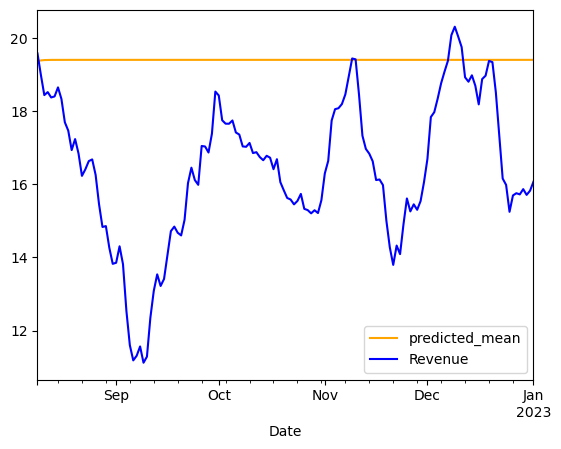

In [33]:
# Plot predictions from the test model.
predtest.plot(legend=True, color='Orange')
test_data["Revenue"].plot(legend=True, color='blue')

In [34]:
# Calculate the test mean.
test_mean = test_data['Revenue'].mean()
print(f"The test data mean is {round(test_mean, 4)}.")

The test data mean is 16.4148.


In [35]:
# Calculate RMSE.
rmse = sqrt(mean_squared_error(predtest, test_data['Revenue']))
print(f"The root mean squared error is {round(rmse, 4)}.")

The root mean squared error is 3.5918.


## Set Up Forecast Model

In [36]:
# Set the prediction model.
predict_model = ARIMA(med_time_series['Revenue'], order=(1,1,0))

# Fit the prediction model to the data.
predict_model = predict_model.fit()

## Make Future Revenue Predictions

In [37]:
# Define future dates and set up an index.
index_future_dates = pd.date_range(start='2023-01-01', end='2023-01-31')
print(index_future_dates)

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10', '2023-01-11', '2023-01-12',
               '2023-01-13', '2023-01-14', '2023-01-15', '2023-01-16',
               '2023-01-17', '2023-01-18', '2023-01-19', '2023-01-20',
               '2023-01-21', '2023-01-22', '2023-01-23', '2023-01-24',
               '2023-01-25', '2023-01-26', '2023-01-27', '2023-01-28',
               '2023-01-29', '2023-01-30', '2023-01-31'],
              dtype='datetime64[ns]', freq='D')


In [38]:
# Make future predictions.
predict = predict_model.predict(start=len(med_time_series), end=len(med_time_series)+30, typ='levels').rename('Future ARIMA Forecasted Revenue')

# Set index.
predict.index=index_future_dates.rename('Date')

# Define columns.
predict_data = pd.DataFrame(predict)
predict_data.columns = ['Revenue']
print(predict_data)

              Revenue
Date                 
2023-01-01  16.171559
2023-01-02  16.213862
2023-01-03  16.231384
2023-01-04  16.238642
2023-01-05  16.241649
2023-01-06  16.242894
2023-01-07  16.243410
2023-01-08  16.243623
2023-01-09  16.243712
2023-01-10  16.243749
2023-01-11  16.243764
2023-01-12  16.243770
2023-01-13  16.243773
2023-01-14  16.243774
2023-01-15  16.243774
2023-01-16  16.243774
2023-01-17  16.243774
2023-01-18  16.243774
2023-01-19  16.243774
2023-01-20  16.243774
2023-01-21  16.243774
2023-01-22  16.243774
2023-01-23  16.243774
2023-01-24  16.243774
2023-01-25  16.243774
2023-01-26  16.243774
2023-01-27  16.243774
2023-01-28  16.243774
2023-01-29  16.243774
2023-01-30  16.243774
2023-01-31  16.243774


## Plot Predicted Future Revenue

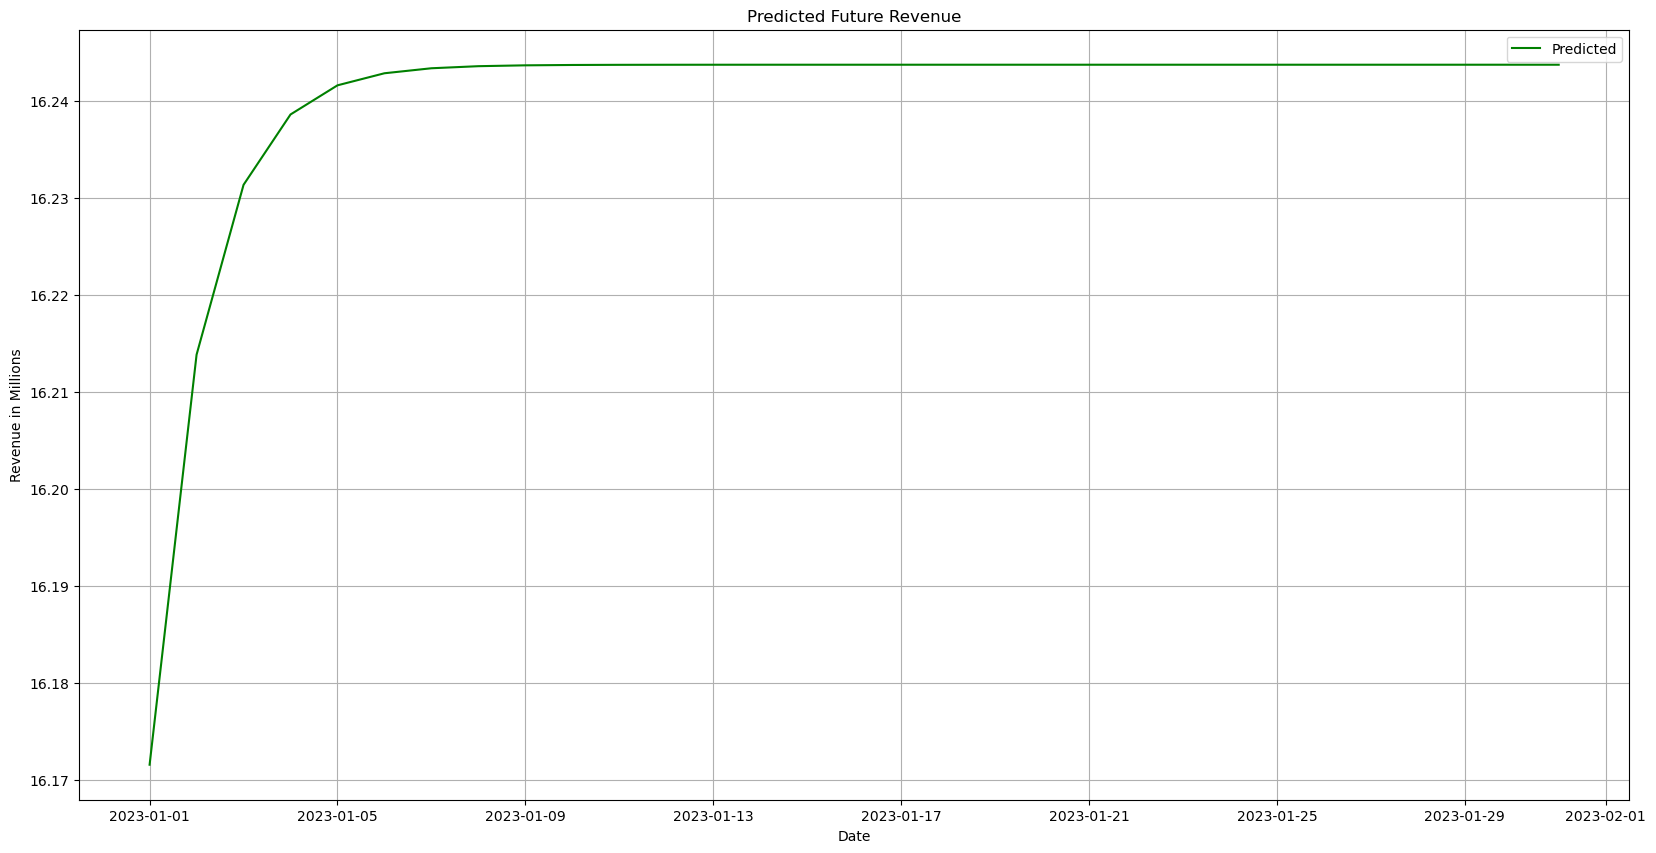

In [39]:
# Plot predicted revenue values.
plt.figure(figsize = (20, 10))
pred_revenue = plt.plot(predict_data['Revenue'], color='green', label='Predicted')
plt.legend(loc='best')
plt.title('Predicted Future Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions')
plt.grid(True)
plt.show()

## Calculate Confidence Intervals

In [48]:
# Generate predictions for the confidence interval.
dynamic_forecast = predict_model.get_prediction(start='2023-01-01', end='2023-01-31', dynamic=True)

In [49]:
# Get the prediction mean.
mean_forecast = dynamic_forecast.conf_int()

In [50]:
# Get confidence intervals of the predictions.
confidence_intervals = dynamic_forecast.conf_int()

In [51]:
# Select the lower and upper confidence limits.
upper_limits = confidence_intervals.loc[:,'upper Revenue']
lower_limits = confidence_intervals.loc[:, 'lower Revenue']

In [52]:
# 
print(mean_forecast)

            lower Revenue  upper Revenue
2023-01-01      15.006023      16.734053
2023-01-02      14.393060      17.386093
2023-01-03      13.868668      17.926672
2023-01-04      13.417845      18.384199
2023-01-05      13.023356      18.781465
2023-01-06      12.671492      19.134479
2023-01-07      12.352312      19.454135
2023-01-08      12.058752      19.747893
2023-01-09      11.785758      20.020969
2023-01-10      11.529647      20.277114
2023-01-11      11.287676      20.519099
2023-01-12      11.057753      20.749027
2023-01-13      10.838249      20.968534
2023-01-14      10.627867      21.178917
2023-01-15      10.425558      21.381226
2023-01-16      10.230458      21.576326
2023-01-17      10.041848      21.764936
2023-01-18       9.859121      21.947663
2023-01-19       9.681758      22.125026
2023-01-20       9.509314      22.297471
2023-01-21       9.341399      22.465386
2023-01-22       9.177675      22.629110
2023-01-23       9.017843      22.788942
2023-01-24      

## Plot Actual and Predicted Revenue

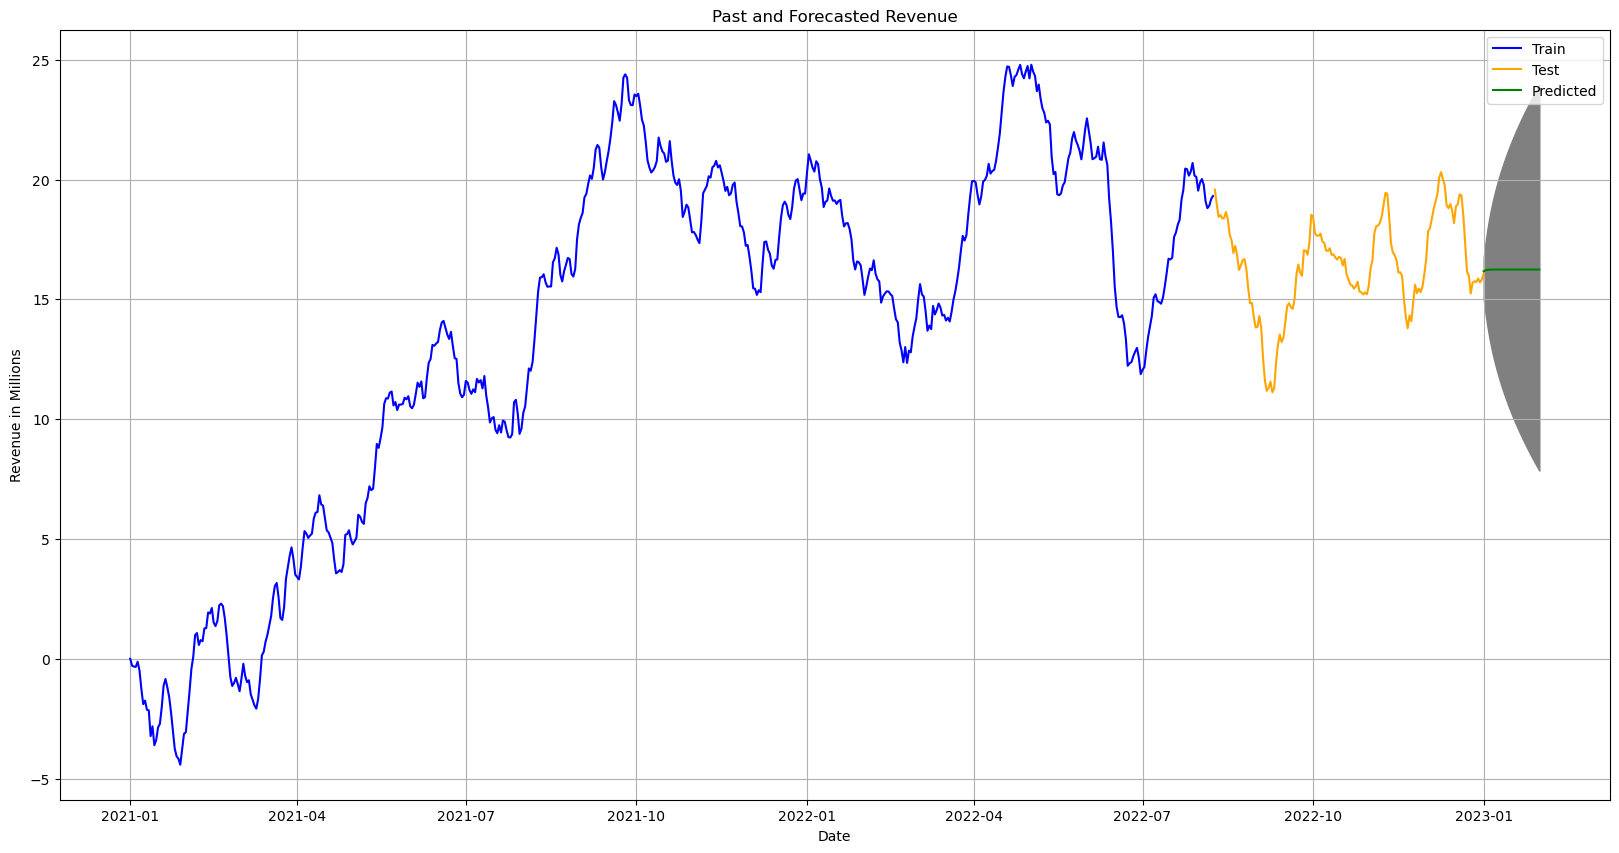

In [53]:
plt.figure(figsize = (20, 10))
train_revenue = plt.plot(train_data['Revenue'], color='blue', label='Train')
test_revenue = plt.plot(test_data['Revenue'], color='orange', label='Test')
pred_revenue = plt.plot(predict_data['Revenue'], color='green', label='Predicted')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='gray')
plt.legend(loc='best')
plt.title('Past and Forecasted Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions')
plt.grid(True)
plt.show()

## Export Data Set with Predicted Future Revenue

In [46]:
# Combine original and predicted
med_time_series_combined = pd.concat([med_time_series, predict_data], axis=0)

# Review the new data frame.
print(med_time_series_combined)

              Revenue  Stationary_Series
Date                                    
2021-01-01   0.000000           0.000000
2021-01-02  -0.292356          -0.292356
2021-01-03  -0.327772          -0.035416
2021-01-04  -0.339987          -0.012215
2021-01-05  -0.124888           0.215100
...               ...                ...
2023-01-27  16.243774                NaN
2023-01-28  16.243774                NaN
2023-01-29  16.243774                NaN
2023-01-30  16.243774                NaN
2023-01-31  16.243774                NaN

[762 rows x 2 columns]


In [47]:
# Export the cleaned data set as a .csv file.
med_time_series_combined.to_csv("med_time_series_combined.csv")